# Part 1: Sequence Tagging - NER
## Installing Dependencies

In [3]:
# Run this cell if you have not downloaded any of these libraries before
# Please use a Python 3.10 Kernel
! pip install --upgrade gensim
! pip install seqeval
! pip install keras_tuner
! pip install tensorflow-addons
! pip install seqeval
! pip install matplotlib
! pip install pydot graphviz
# Download and instantiate a gensim model with word2vec-google-news-300 vectors
import gensim.downloader
w2v = gensim.downloader.load('word2vec-google-news-300')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 33.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 21.0 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=b4e50ee4ce15ff5dd50e9bf56830bdbb0e7d6ab65e9aa1ca3d08ce0e1a1dbc56
  Stored in directory: /Users/chaitanya/Library/Caches/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached charset_normalizer-3.3.2-cp310-cp310-macosx_10_9_x86_64.whl.metadata (33 kB)
  Using cached idna-3.4-py3-none-any.whl (61 kB)
  Using cached urllib3-2.0.7-py3-none-any.whl.metadata (6.6 kB)
  Using cached certifi-2023.7.22-py3-none-any.whl.metadata (2.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 5.2 MB/

## 1.1 Word Embedding

In [1]:
# Change these variables to the paths of the train, testa and testb files
# on your computer before running this notebook
train_path = "/Users/chaitanya/Documents/NTU/Y3S1/SC4002 NLP/sc4002-project/conll2003/eng.train"
testa_path = "/Users/chaitanya/Documents/NTU/Y3S1/SC4002 NLP/sc4002-project/conll2003/eng.testa"
testb_path = "/Users/chaitanya/Documents/NTU/Y3S1/SC4002 NLP/sc4002-project/conll2003/eng.testb"

### Question 1.1

In [4]:
similar_student = w2v.most_similar("student")
print("Most similar word to 'student':", similar_student[0][0])
print("Cosine similarity:", similar_student[0][1])

similar_Apple = w2v.most_similar("Apple")
print("Most similar word to 'Apple':", similar_Apple[0][0])
print("Cosine similarity:", similar_Apple[0][1])

similar_apple = w2v.most_similar("apple")
print("Most similar word to 'apple':", similar_apple[0][0])
print("Cosine similarity:", similar_apple[0][1])

Most similar word to 'student': students
Cosine similarity: 0.7294867038726807
Most similar word to 'Apple': Apple_AAPL
Cosine similarity: 0.7456985712051392
Most similar word to 'apple': apples
Cosine similarity: 0.720359742641449


### Question 1.2

In [5]:
# Size of Training File
count = 0

with open(train_path, "r") as file:
    for line in file:
        if line.strip() == '':
            count += 1

print(f"Size of training file: {count}")

Size of training file: 14986


In [6]:
# Size of Development File
count = 0

with open(testa_path, "r") as file:
    for line in file:
        if line.strip() == '':
            count += 1

print(f"Size of development file: {count}")

Size of development file: 3465


In [7]:
# Size of Test File
count = 0

with open(testb_path, "r") as file:
    for line in file:
        if line.strip() == '':
            count += 1

print(f"Size of test file: {count}")

Size of test file: 3683


### Question 1.3

In [4]:
def load_data_and_labels_two(filename,encoding='utf-8'):
    """
    This function also works same like the previous one but here
    I am not removing the special charecters.
    """
    words=[]
    parser=[]
    ner=[]
    sent=[]
    label2=[]
    label3=[]
    tempz="""(),.<>?$#@"!%&*:;'~`^=-_+\|{}[]/"""
    removal=[i for i in tempz]

    with open(filename, encoding=encoding) as f:
        for line in f:
            line = line.rstrip()
            if line:
                word, pos_,parser_,ner_ = line.split()
                if word!="-DOCSTART-" and word not in removal:
                    words.append(word)
                    parser.append(parser_)
                    ner.append(ner_)
            else:
                if words!=[] and ner!=[] and parser!=[]:
                    sent.append(words)
                    label2.append(parser)
                    label3.append(ner)
                    words, parser, ner = [], [], []

    return sent, label3

X_train, Y_train = load_data_and_labels_two(train_path)
X_valid, Y_valid= load_data_and_labels_two(testa_path)
X_test, Y_test = load_data_and_labels_two(testb_path)

In [5]:
import numpy as np
from keras.utils import to_categorical

CASING_DIM = 4
CASES = ["xx", "XX", "Xx", "xX"]
case2id = {c: i for i, c in enumerate(CASES)}

def get_casing(word):
  """
  Return the casing information in a numpy array.

  Args:
    word(str): input word, E.g. Hello

  Returns:
    np.array(shape=(CASING_DIM,)): encoded casing

  Hint: You might find the one-hot encoding useful.
  """
  casing = np.zeros(shape=(CASING_DIM,))

  # all lowercase
  if word.islower():
    case = "xx"
  # all uppercase
  elif word.isupper():
    case = "XX"
  # starts with capital
  elif word[0].isupper():
    case = "Xx"
  # has non-initial capital
  else:
    case = "xX"

  casing = to_categorical(case2id[case], len(CASES))

  assert casing.shape == (CASING_DIM,)
  return casing

print("case(hello) =", get_casing('hello'))
print("case(Hello) =", get_casing('Hello'))
print("case(HELLO) =", get_casing('HELLO'))
print("case(hEllO) =", get_casing('hEllO'))

case(hello) = [1. 0. 0. 0.]
case(Hello) = [0. 0. 1. 0.]
case(HELLO) = [0. 1. 0. 0.]
case(hEllO) = [0. 0. 0. 1.]


In [6]:
import copy

def process_data(X_train, Y_train, window_size=5):
    # Add <s> and </s> tags to each sentence in X_train
    X_train = [['<s>'] + sentence + ['</s>'] for sentence in X_train]
    X_train = [['<s>'] + sentence + ['</s>'] for sentence in X_train]

    # Create windows of the specified size for each sentence
    # Extract Y tags for the middle word
    X_window = []
    Y_window = []

    for sentence, labels in zip(X_train, Y_train):
        for i in range(len(sentence) - window_size + 1):
            window = sentence[i:i + window_size]
            X_window.append(window)
            Y_window.append(labels[i])

    return X_window, Y_window

X_train_copy = copy.deepcopy(X_train)
Y_train_copy = copy.deepcopy(Y_train)
X_train_pp, Y_train_pp = process_data(X_train_copy, Y_train_copy)

X_valid_copy = copy.deepcopy(X_valid)
Y_valid_copy = copy.deepcopy(Y_valid)
X_valid_pp, Y_valid_pp = process_data(X_valid_copy, Y_valid_copy)

X_test_copy = copy.deepcopy(X_test)
Y_test_copy = copy.deepcopy(Y_test)
X_test_pp, Y_test_pp = process_data(X_test_copy, Y_test_copy)

In [7]:
unique_strings = set()
for sublist in X_train_pp:
    unique_strings.update(sublist)
for sublist in X_valid_pp:
    unique_strings.update(sublist)
for sublist in X_test_pp:
    unique_strings.update(sublist)

unique_strings_list = list(unique_strings)
print("Unique strings from all lists:")
print(len(unique_strings_list))

Unique strings from all lists:
30270


In [8]:
tok2id = {w:i for i, w in enumerate(unique_strings_list)}
len(tok2id)

30270

In [9]:
def one_hot_encode_labels(label_list):
    # Flatten the label list to get a list of unique labels
    unique_labels = {'O', 'I-MISC', 'I-ORG', 'B-LOC', 'B-ORG', 'I-PER', 'B-MISC', 'I-LOC'}

    # Create a dictionary to map labels to unique integers
    label2id = {'O': 0, 'I-MISC': 1, 'I-ORG': 2, 'B-ORG': 3, 'B-LOC': 4, 'I-PER': 5, 'B-MISC': 6, 'I-LOC': 7}

    # Initialize the list to store the one-hot encoded labels
    one_hot_encoded_labels = [to_categorical(label2id[label], len(unique_labels)) for label in label_list]

    return one_hot_encoded_labels

def process_list(input_list, y_list, tok2id, get_casing):
    # Initialize the output lists
    integer_list = []
    casing_list = []

    for sublist in input_list:
        integer_sublist = []
        casing_sublist = []

        for word in sublist:
            # Append the integer and casing information to the sublists
            integer_sublist.append(tok2id[word])
            casing_sublist.append(get_casing(word))

        integer_list.append(integer_sublist)
        casing_list.append(casing_sublist)

    return (integer_list, casing_list) , one_hot_encode_labels(y_list)

(w_train, c_train), y_train = process_list(X_train_pp, Y_train_pp, tok2id, get_casing)
(w_valid, c_valid), y_valid = process_list(X_valid_pp, Y_valid_pp, tok2id, get_casing)
(w_test, c_test), y_test = process_list(X_test_pp, Y_test_pp, tok2id, get_casing)

In [10]:
print("w_valid[0] =", w_valid[0])
print("c_valid[0] =", c_valid[0])
print("y_valid[0] =", y_valid[0])

w_valid[0] = [20657, 20657, 2881, 7469, 8158]
c_valid[0] = [array([1., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0.], dtype=float32), array([0., 1., 0., 0.], dtype=float32), array([0., 1., 0., 0.], dtype=float32), array([0., 1., 0., 0.], dtype=float32)]
y_valid[0] = [1. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
import numpy as np
word2vec = {}
for vocab in w2v.index_to_key:
    coefs = np.asarray(w2v[vocab], dtype='float32')
    word2vec[vocab] = coefs

print('Found %s word vectors.' % len(word2vec))

Found 3000000 word vectors.


In [22]:
import numpy as np
EMBEDDING_DIM = 300
# It is a good practice to initialize out-of-vocabulary tokens
# Initialize with the embeddings' mean
mean_embed = np.mean(np.array(list(word2vec.values())), axis=0)

# Create the embedding matrix according to our vocabulary
embedding_matrix = np.zeros((len(tok2id), EMBEDDING_DIM))
for word, i in tok2id.items():
  embedding_matrix[i] = word2vec.get(word, mean_embed)

print("embedding_matrix.shape =", embedding_matrix.shape)

embedding_matrix.shape = (30270, 300)


In [23]:
NUM_NEIGHBORS = 2
WINDOW_SIZE = 2 * NUM_NEIGHBORS + 1
NUM_CLASSES = 8

from keras.layers import Input, Embedding, Dense, Dropout, Flatten, concatenate
from keras.initializers import Constant
from keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, SpatialDropout1D, Bidirectional, Conv1D, concatenate, TimeDistributed

# NN Model Definition
def get_window_based_ner_model():
  window = Input(shape=(WINDOW_SIZE,), dtype='int64', name='window')
  casing = Input(shape=(4*WINDOW_SIZE,), dtype='float32', name='casing')
  embedding_layer = Embedding(
      input_dim=len(tok2id),
      output_dim=EMBEDDING_DIM,
      embeddings_initializer=Constant(embedding_matrix),
      input_length=WINDOW_SIZE,
  )
  window_embeds = Flatten()(embedding_layer(window))
  input_ = concatenate([window_embeds, casing])
  x = Dense(512, activation='relu')(input_)
  x = Dropout(0.4)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.4)(x)
  output = Dense(NUM_CLASSES, activation='softmax')(x)
  model = Model([window, casing], output)

  return model

In [24]:
#from keras.utils.plot_model import model_to_dot
# Let's create and visualize the NER model
ner_model = get_window_based_ner_model()
ner_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['acc'])
ner_model.summary()
#SVG(model_to_dot(ner_model,show_shapes=True).create(prog='dot', format='svg'))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 window (InputLayer)         [(None, 5)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 5, 300)               9081000   ['window[0][0]']              
                                                                                                  
 flatten_1 (Flatten)         (None, 1500)                 0         ['embedding_1[0][0]']         
                                                                                                  
 casing (InputLayer)         [(None, 20)]                 0         []                            
                                                                                            

In [25]:
import tensorflow as tf
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

# Generate svg plot of model structure for report
ner_model_graph = model_to_dot(ner_model, show_shapes=True, show_layer_names=True, rankdir='TB')
ner_model_graph.set_size('"12,12"')  #

# Convert to SVG
svg_image = ner_model_graph.create_svg()

# Save SVG to a file
with open("ner_model_architecture.svg", "wb") as file:
    file.write(svg_image)

In [26]:
w_train, c_train, y_train = np.array(w_train), np.array(c_train), np.array(y_train)
w_valid, c_valid, y_valid = np.array(w_valid), np.array(c_valid), np.array(y_valid)
w_test, c_test, y_test = np.array(w_test), np.array(c_test), np.array(y_test)

In [27]:
def reshape_2d_list_to_1d(arr_2d):
    # Concatenate the rows of the 2D list into a single array
    res = np.empty((arr_2d.shape[0], 20,))
    for i, array in enumerate(arr_2d):
        reshaped_array = array.reshape(20)
        res[i] = reshaped_array

    res = np.array(res)
    return res


c_train_reshaped = reshape_2d_list_to_1d(c_train)
c_valid_reshaped =reshape_2d_list_to_1d(c_valid)
c_test_reshaped =reshape_2d_list_to_1d(c_test)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
# Use early stopping with patience 1 to stop the model once the f1_score is no longer increasing
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=1)

In [29]:
from seqeval.metrics import f1_score
from seqeval.scheme import IOB2
from seqeval.scheme import IOB1
def f1_score_eval(y_true, y_pred):
    flipped_dict = {0: 'O', 1: 'I-MISC', 2: 'I-ORG', 3: 'B-ORG', 4: 'B-LOC', 5: 'I-PER', 6: 'B-MISC', 7: 'I-LOC'}
    
    label_list = []
    #print(y_pred.shape)
    for i in y_pred:
        class_num = np.argmax(i)
        label_list.append(flipped_dict.get(class_num))
    #print(len(label_list))

    index = 0
    y_pred_label = copy.deepcopy(y_true)
    
    for i, sentences in enumerate(y_true):
        for j, words in enumerate(sentences):
            y_pred_label[i][j] = label_list[index]
            index+=1

    print(f"f1_score: {f1_score(y_true, y_pred_label, mode='strict', scheme=IOB1)}")

In [30]:
from seqeval.metrics import f1_score
from tensorflow.keras.callbacks import Callback, EarlyStopping

class F1ScoreCallback(Callback):
    def __init__(self, val_data, val_labels):
        super(F1ScoreCallback, self).__init__()
        self.val_data = val_data
        self.val_labels = val_labels

    def on_epoch_end(self, epoch, logs=None):
        pred = self.model.predict(self.val_data)
        return f1_score_eval(Y_valid, pred)


f1_callback = F1ScoreCallback((w_valid, c_valid_reshaped), y_valid)

In [31]:
BATCH_SIZE = 512
# Train the model and visualize the traning at the end
ner_model_hist = ner_model.fit(
    [w_train, c_train_reshaped], y_train,
    epochs=10,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, f1_callback],
    validation_data=([w_valid, c_valid_reshaped], y_valid)
)


Epoch 1/10
1401/1401 [==============================] - 5s 4ms/step
f1_score: 0.8593598448108632
349/349 [==============================] - 30s 84ms/step - loss: 0.1360 - acc: 0.9572 - val_loss: 0.0860 - val_acc: 0.9752
Epoch 2/10
1401/1401 [==============================] - 5s 4ms/step
f1_score: 0.8854022191400831
349/349 [==============================] - 32s 93ms/step - loss: 0.0518 - acc: 0.9846 - val_loss: 0.0643 - val_acc: 0.9817
Epoch 3/10
1401/1401 [==============================] - 6s 4ms/step
f1_score: 0.8880201546346973
349/349 [==============================] - 31s 89ms/step - loss: 0.0301 - acc: 0.9912 - val_loss: 0.0677 - val_acc: 0.9823
Epoch 3: early stopping


In [32]:
prediction = ner_model.predict((w_test, c_test_reshaped))
prediction

1270/1270 [==============================] - 4s 3ms/step


array([[9.9996316e-01, 1.6608242e-06, 3.1386233e-05, ..., 8.8719858e-08,
        2.0108097e-07, 3.1864522e-06],
       [2.6146732e-03, 2.9091525e-04, 6.6198312e-02, ..., 3.0501327e-04,
        8.4625171e-05, 9.3024510e-01],
       [9.9972349e-01, 7.2929856e-07, 2.7282623e-04, ..., 1.8221392e-07,
        1.7136442e-07, 2.1580395e-06],
       ...,
       [9.9999917e-01, 6.0371269e-07, 2.7512064e-09, ..., 2.3329910e-07,
        1.2681688e-09, 3.9318375e-12],
       [9.9999976e-01, 1.3366136e-07, 1.1822991e-08, ..., 1.3831213e-07,
        1.1221910e-09, 9.2715766e-11],
       [5.3358704e-06, 1.3418988e-06, 5.2180513e-07, ..., 9.9999273e-01,
        1.2403423e-08, 1.6259594e-07]], dtype=float32)

In [33]:
f1_score_eval(Y_test, prediction)

f1_score: 0.8189445196211096


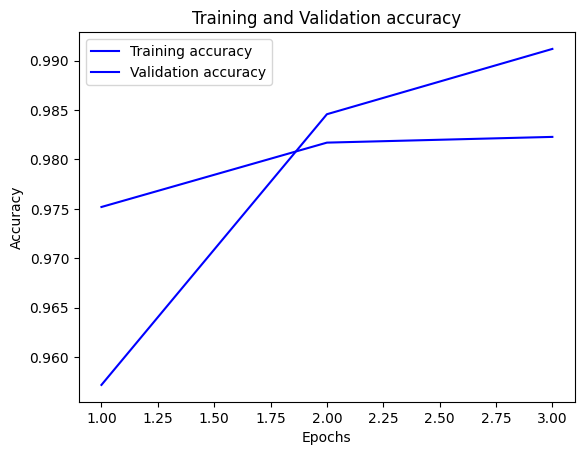

In [38]:
import matplotlib.pyplot as plt

# Assuming 'accuracy' and 'val_accuracy' are the keys for training and validation accuracy
accuracy = ner_model_hist.history['acc']
val_accuracy = ner_model_hist.history['val_acc']
epochs = range(1, len(accuracy) + 1)
#f1_score = ner_model_hist.history["f1_score"]

# Plot training and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()